In [90]:
%load_ext autoreload
%autoreload 2

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#-------------ACTIVE LEARNING LIBRARY
from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

#------------IMBALANCED DATA SETS LIBRARY
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun
import reg_icp as ricp
import emcm 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# Loading data sets
cell_profiler = pd.read_csv('/home/jovyan/Thesis_ActLearn_DOP_2022/main/supervised_learning/regression_data_batchA.csv')
print(f'There are {len(cell_profiler)} rows in the Batch A')

There are 5167 rows in the Batch A


In [92]:
# Selecting features according to the paper
group1 = [col for col in cell_profiler.columns if ('Granu' in col  and 'SYTO' in col) or ('Inten' in col and 'SYTO' in col) and not 'Location' in col and not 'Radial' in col]
group2 = [col for col in cell_profiler.columns if ('Granu' in col  and 'CONC' in col) or ('Inten' in col and 'CONC' in col) and not 'Location' in col and not 'Radial' in col]
group3 = [col for col in cell_profiler.columns if 'Correla' in col or 'Neig' in col]

filtered_features = group1+group2+group3

# Filtering
filtered_cell_profiler = cell_profiler[filtered_features+['Target']]

In [93]:
# We get the input values
X_filtered =  filtered_cell_profiler.iloc[:,:-1].to_numpy()

# Re-scale
scaler = StandardScaler()
X_filtered = pd.DataFrame(scaler.fit_transform(X_filtered))
X_filtered = X_filtered.to_numpy()

y = 1000*filtered_cell_profiler.iloc[:,-1].to_numpy()

In [94]:
type(X_filtered)

numpy.ndarray

In [95]:
# Parameters for ML model
train_size = 0.1
test_size = 0.3

# split dataset into train(- %), test(- %), unlabel(- %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_filtered, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [96]:
print(f'The inicial training set has size {len(x_train)}')
print(f'The inicial pool set has size {len(x_pool)}')
print(f'The inicial test set has size {len(x_test)}')

The inicial training set has size 361
The inicial pool set has size 3255
The inicial test set has size 1551


In [97]:
#Target from supervised machine learning
target = 0.3215
linear_model_v2 = Ridge(alpha=1.3, random_state=0)

# Parameters for AL
k_members = 3

#Define query strategy 
query_str = emcm.emcm_query
    
performance_history_v2 = []

#Fit model to initial data
linear_model_v2.fit(x_train, y_train)

#Making predictions
y_pred = linear_model_v2.predict(x_test)

#Calculate and report our model's accuracy.
model_accuracy = mean_squared_error(y_pred , y_test)

# Save our model's performance for plotting.
performance_history_v2.append(model_accuracy)
collections = 0

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy emcm.
while len(x_pool) > 0:
    
    if collections == 0:
        print('Inside AL')
    
    #Query for a new point
    query_index, query_instance = query_str(x_train, y_train, x_pool, linear_model_v2, k_members)
    collections += 1
    
    # Teach our ActiveLearner model the record it has requested.
    XX, yy = x_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    x_train = np.append(x_train, XX, axis = 0)
    y_train = np.append(y_train, yy, axis = 0)

    # Remove the queried instance from the unlabeled pool.
    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)
    
    # Re- training in new data
    linear_model_v2.fit(x_train, y_train)
    
    #Predict given the new point
    y_pred = linear_model_v2.predict(x_test)
    
    #Store performance
    model_accuracy = mean_squared_error(y_pred , y_test)
    performance_history_v2.append(model_accuracy)

    if collections % 100 == 0:
        print('Accuracy after query {n}: {acc:0.4f}'.format(n = collections, acc = model_accuracy))
    
    if abs(target - model_accuracy) < 0.005:
        print(f'Target reached! \n Number of queries performed {collections}')
        break
        

Inside AL
Accuracy after query 100: 0.4322
Accuracy after query 200: 0.4142
Accuracy after query 300: 0.4131
Accuracy after query 400: 0.3970
Accuracy after query 500: 0.3801
Accuracy after query 600: 0.3682
Accuracy after query 700: 0.3627
Accuracy after query 800: 0.3577
Accuracy after query 900: 0.3551
Accuracy after query 1000: 0.3508
Accuracy after query 1100: 0.3506
Accuracy after query 1200: 0.3492
Accuracy after query 1300: 0.3490
Accuracy after query 1400: 0.3486
Accuracy after query 1500: 0.3506
Accuracy after query 1600: 0.3488
Accuracy after query 1700: 0.3466
Accuracy after query 1800: 0.3463
Accuracy after query 1900: 0.3449
Accuracy after query 2000: 0.3440
Accuracy after query 2100: 0.3417
Accuracy after query 2200: 0.3414
Accuracy after query 2300: 0.3400
Accuracy after query 2400: 0.3398
Accuracy after query 2500: 0.3400
Accuracy after query 2600: 0.3399
Accuracy after query 2700: 0.3390
Accuracy after query 2800: 0.3387
Accuracy after query 2900: 0.3387
Accuracy afte

In [100]:
d_v2_BatchA = {'performance_history_v2':performance_history_v2,'collections':collections}
with open('d_v2_BatchA.pkl', 'wb') as f:
    pickle.dump(d_v2_BatchA, f)

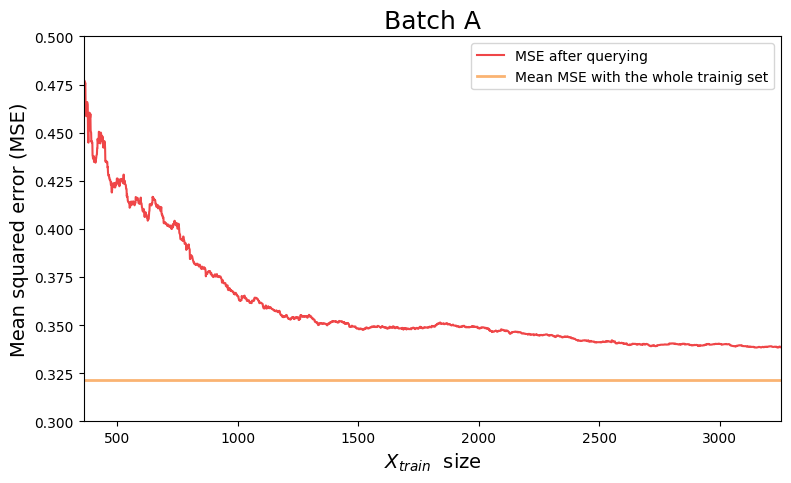

In [102]:
xxx = np.arange(361, 3257+360, 1)
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(xxx, performance_history_v2, color=[.937, .275, .282], linewidth=1.5)
ax.set_ylim([0.3, 0.5])
ax.set_xlim([361, 3255])
plt.axhline(y = 0.3215, color=[.98, .702, .447], linestyle='-', linewidth=2)

ax.set_ylabel('Mean squared error (MSE)', color="black", fontsize=14)   
ax.set_xlabel('$X_{train}$  size', color="black", fontsize=14)
ax.set_title('Batch A', color="black", fontsize=18)
ax.legend(['MSE after querying', 'Mean MSE with the whole trainig set'])

#plt.savefig('Figures/AL_1_Ridge_regre_batchA.jpg',bbox_inches='tight', dpi=150)

plt.show()

In [103]:
# Parameters for ML model
train_size = 0.2
test_size = 0.2

# split dataset into train(- %), test(- %), unlabel(- %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_filtered, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [104]:
print(f'The inicial training set has size {len(x_train)}')
print(f'The inicial pool set has size {len(x_pool)}')
print(f'The inicial test set has size {len(x_test)}')

The inicial training set has size 826
The inicial pool set has size 3307
The inicial test set has size 1034


In [105]:
#Target from supervised machine learning
target = 0.3215
linear_model_v3 = Ridge(alpha=1.3, random_state=0)

# Parameters for AL
k_members = 3

#Define query strategy 
query_str = emcm.emcm_query
    
performance_history_v3 = []

#Fit model to initial data
linear_model_v3.fit(x_train, y_train)

#Making predictions
y_pred = linear_model_v3.predict(x_test)

#Calculate and report our model's accuracy.
model_accuracy = mean_squared_error(y_pred , y_test)

# Save our model's performance for plotting.
performance_history_v3.append(model_accuracy)
collections = 0

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy emcm.
while len(x_pool) > 0:
    
    if collections == 0:
        print('Inside AL')
    
    #Query for a new point
    query_index, query_instance = query_str(x_train, y_train, x_pool, linear_model_v3, k_members)
    collections += 1
    
    # Teach our ActiveLearner model the record it has requested.
    XX, yy = x_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    x_train = np.append(x_train, XX, axis = 0)
    y_train = np.append(y_train, yy, axis = 0)

    # Remove the queried instance from the unlabeled pool.
    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)
    
    # Re- training in new data
    linear_model_v3.fit(x_train, y_train)
    
    #Predict given the new point
    y_pred = linear_model_v3.predict(x_test)
    
    #Store performance
    model_accuracy = mean_squared_error(y_pred , y_test)
    performance_history_v3.append(model_accuracy)

    if collections % 100 == 0:
        print('Accuracy after query {n}: {acc:0.4f}'.format(n = collections, acc = model_accuracy))
    
    if abs(target - model_accuracy) < 0.005:
        print(f'Target reached! \n Number of queries performed {collections}')
        break

Inside AL
Target reached! 
 Number of queries performed 40


In [108]:
performance_history_v4 = performance_history_v3
collections4 = collections

In [109]:
d_v3_BatchA = {'performance_history_v3':performance_history_v3,'collections':collections}
with open('d_v3_BatchA.pkl', 'wb') as f:
    pickle.dump(d_v3_BatchA, f)

In [88]:
#with open('d_v3_BatchA.pkl', 'rb') as f:
#    loaded_dict = pickle.load(f)

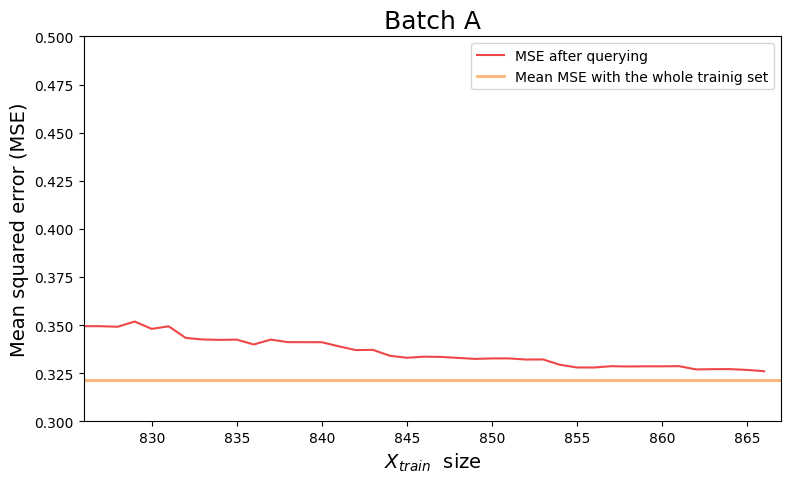

In [111]:
xxx = np.arange(826, len(x_train) + 1, 1)
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(xxx, performance_history_v3, color=[.937, .275, .282], linewidth=1.5)
ax.set_ylim([0.3, 0.5])
ax.set_xlim([826, len(x_train) + 1])
plt.axhline(y = 0.3215, color=[.98, .702, .447], linestyle='-', linewidth=2)

ax.set_ylabel('Mean squared error (MSE)', color="black", fontsize=14)   
ax.set_xlabel('$X_{train}$  size', color="black", fontsize=14)
ax.set_title('Batch A', color="black", fontsize=18)
ax.legend(['MSE after querying', 'Mean MSE with the whole trainig set'])

#plt.savefig('Figures/AL_2_Ridge_regre_batchA.jpg',bbox_inches='tight', dpi=150)

plt.show()

### Adding conformal prediction to the best model

In [112]:
import reg_icp as ricp

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2,random_state=0)
# Split data into proper training set and clibration set
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.3,random_state=0)

In [113]:
## Ridge regression
intervals_ridge, testPred_ridge = ricp.ICPRegression(X_train, y_train, X_calib, y_calib, X_test, linear_model_v3, returnPredictions = False)

In [114]:
icp_result_ridge = pd.DataFrame(intervals_ridge,columns=['Lower_bound', 'Upper_bound'])
icp_result_ridge['y_predicted'] = testPred_ridge
icp_result_ridge['y_test'] = y_test
icp_result_ridge=icp_result_ridge.sort_values(by='y_predicted').reset_index(drop=True)

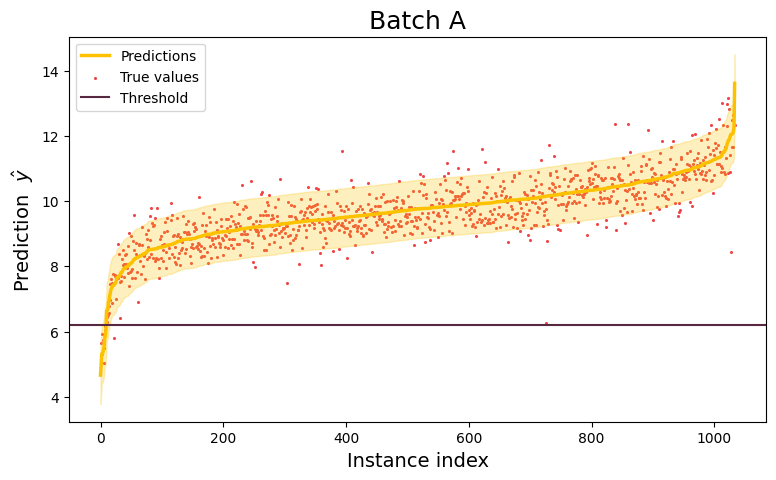

In [118]:
npoints = icp_result_ridge.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(9,5))
ax.plot(icp_result_ridge.index[:npoints],icp_result_ridge['y_predicted'][:npoints], color=[.988, .761, 0], linewidth=2.5)
ax.scatter(icp_result_ridge.index[:npoints],icp_result_ridge['y_test'][:npoints], marker = 'o', s=2,
        color=[.937, .275, .282],linewidth=0.8)
plt.axhline(y=6.2, color=[.345, .157, .255], linestyle='-')

ax.set_ylabel('Prediction  $\^y$', color="black", fontsize=14)   
ax.set_xlabel('Instance index', color="black", fontsize=14)
ax.set_title('Batch A', color="black", fontsize=18)
ax.legend(['Predictions','True values','Threshold'])

ax.fill_between(icp_result_ridge.index[:npoints],icp_result_ridge['Lower_bound'][:npoints], 
                icp_result_ridge['Upper_bound'][:npoints], color=[.988, .761, 0],alpha=0.25)

#plt.savefig('Figures/cp-al_Ridge_regre_batchA.jpg',bbox_inches='tight', dpi=150)
plt.show()